In [3]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from pandas import plotting
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.lines as lines

from sklearn.datasets import load_boston
import copy 
import scipy as sp
from scipy.stats import chi2
from sklearn.covariance import MinCovDet
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

pandas.set_option('display.max_columns', None)
pandas.set_option('display.expand_frame_repr', False)
pandas.set_option('max_colwidth', -1)
pandas.set_option('display.precision', 3)
pandas.set_option('display.float_format', lambda x: '%.3f' % x)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


# Read the data

In [74]:
# para volver a montar reinciar el entorno de ejecución

data = pd.read_csv("https://raw.githubusercontent.com/ArnauAlegre/Prova/main/sample_5000.csv")
data = data.iloc[:, 1:]


print(data[0:10])

   instance_id           artist_name                                            track_name  popularity  acousticness  danceability  duration_ms  energy  instrumentalness key  liveness  loudness   mode  speechiness               tempo obtained_date  valence music_genre
0 81428.000     Fatboy Slim           Sunset (Bird Of Prey) - The Aston Shuffle Remix Edit 21.000      0.004         0.713         214000.000   0.824   0.492              B  0.311     -7.475     Minor 0.041         120.00200000000001  4-Apr        0.454     Electronic
1 83854.000     UNKLE                 Lonely Soul                                          51.000      0.078         0.475         533013.000   0.591   0.055              A  0.109     -7.854     Minor 0.037         ?                   4-Apr        0.123     Electronic
2 82465.000     !!!                   Our Love (U Can Get)                                 43.000      0.169         0.685         -1.000       0.909   0.001              C  0.942     -7.627   

# Multivariate description

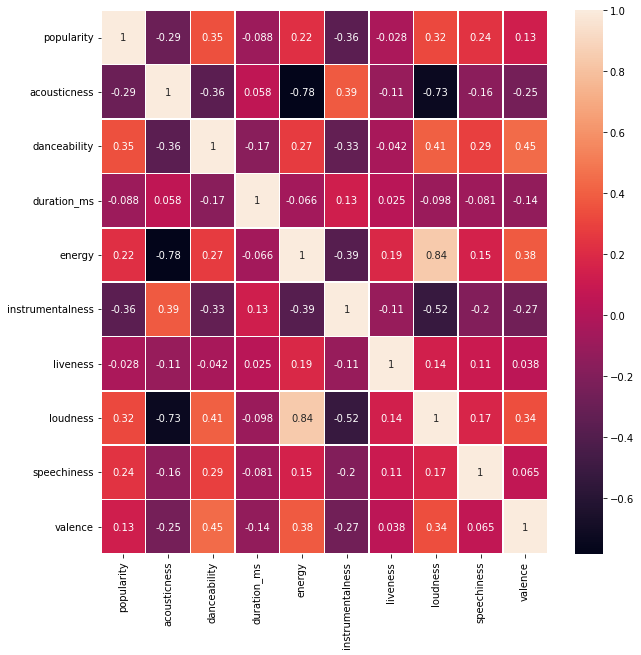

In [22]:
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(data.iloc[:,1:].corr(),annot=True, linewidths=.5, ax=ax)

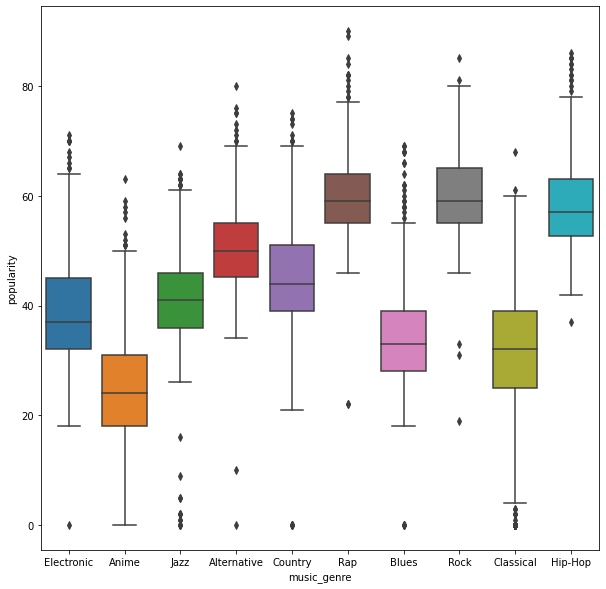

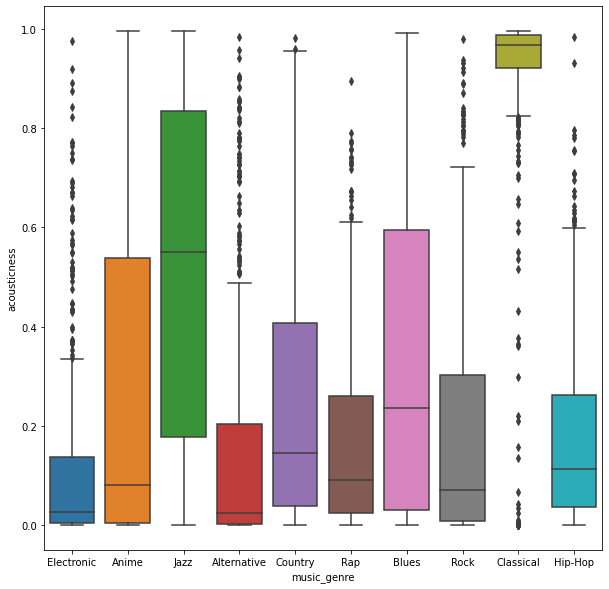

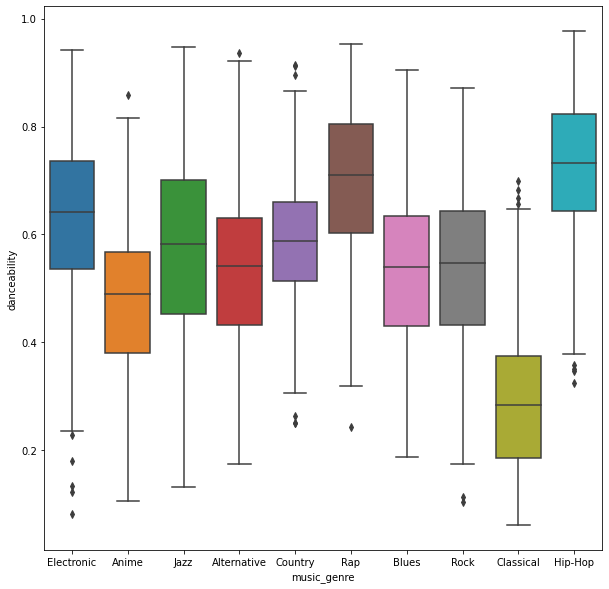

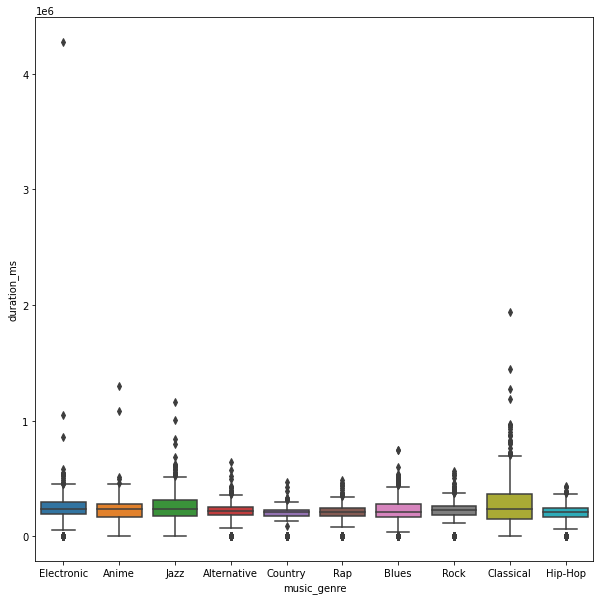

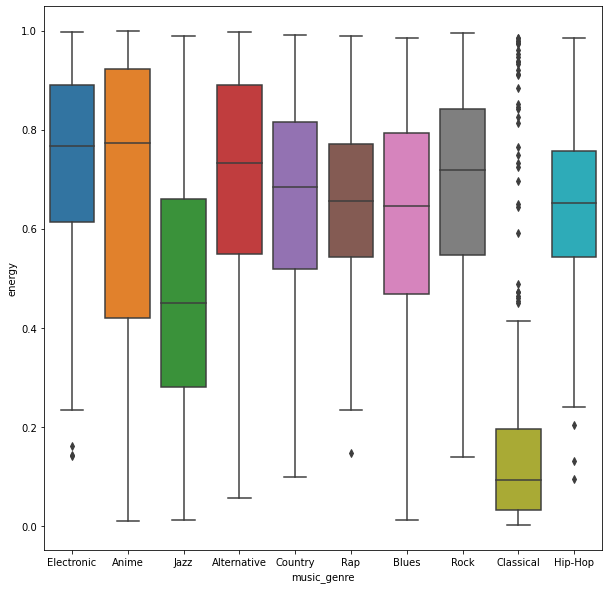

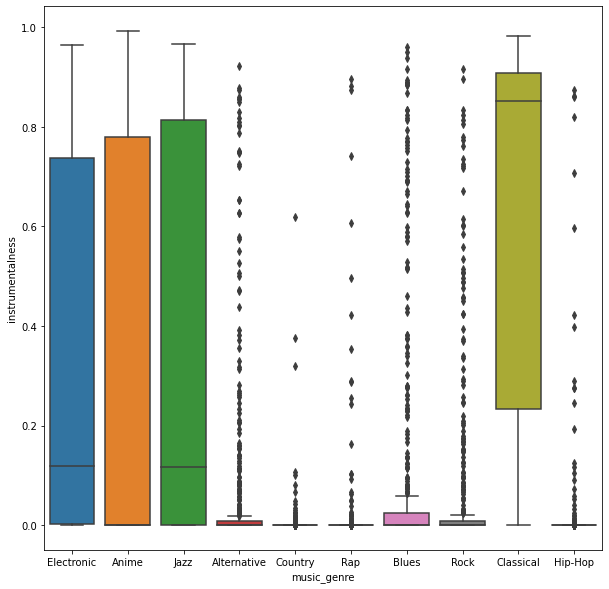

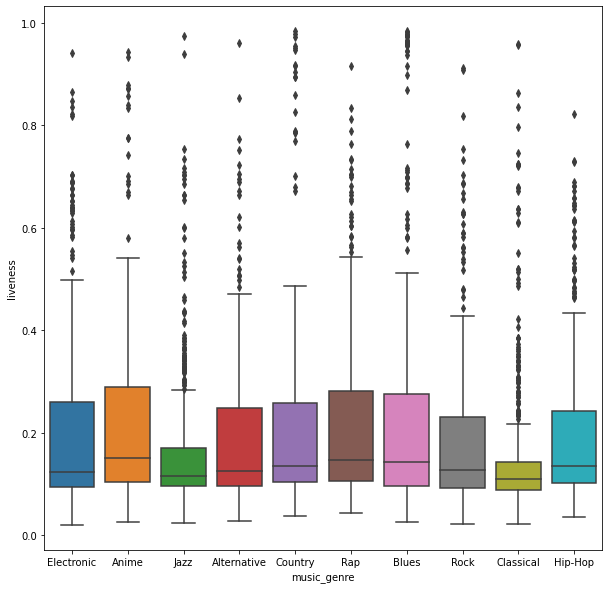

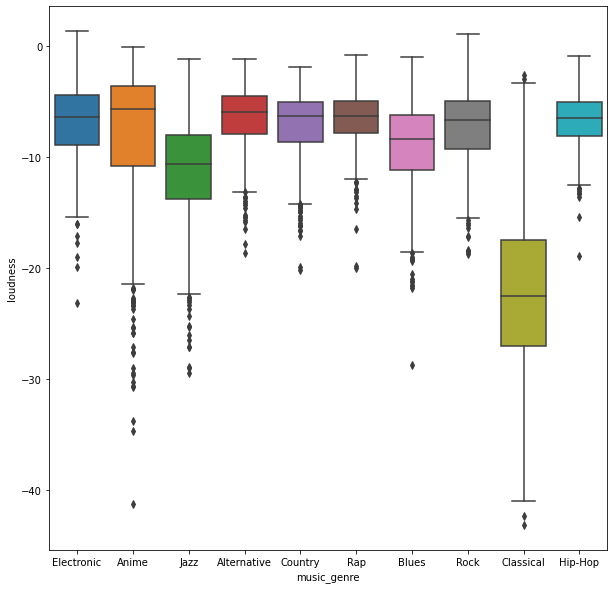

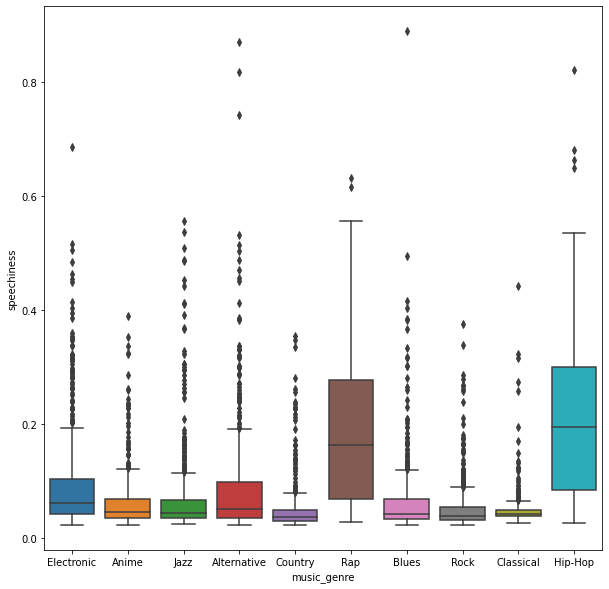

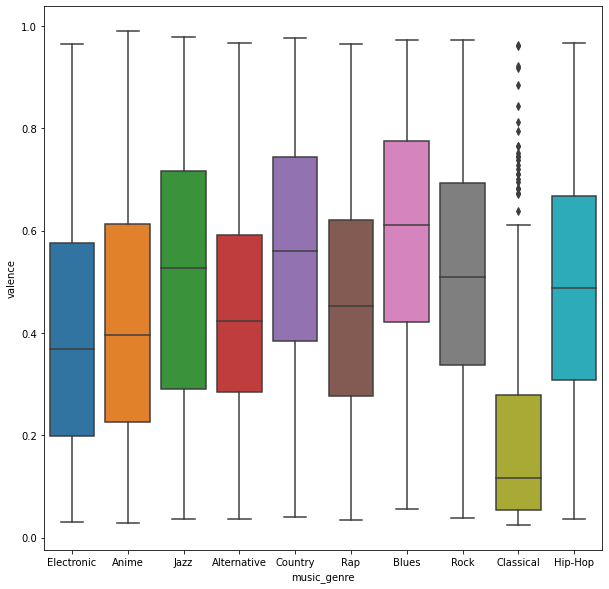

In [34]:
 
names = data.select_dtypes('number').columns
names = names[names!="instance_id"]
for i in range(len(names)):
  fig, ax = plt.subplots(figsize=(10,10))
  sns.boxplot(y = data[names[i]], x = data['music_genre'], ax=ax )


# Data cleaning

## Variable instance_id
We will detele this variable because it does not provide any significant data to help us with our predictions.

In [47]:
data=data.loc[:, data.columns!='instance_id']

## Variable artist_name
We do nothing for this variable

In [ ]:
#data.artist_name.describe()
#data=data.loc[:, data.columns!='artist_name']

## Variable track_name
We do nothing for this variable

In [ ]:
#data=data.loc[:, data.columns!='track_name']

## Variable popularity
This variable provides information about the popularity of the song with a scale from 0 to 100, according to Spotify evaluation methods.

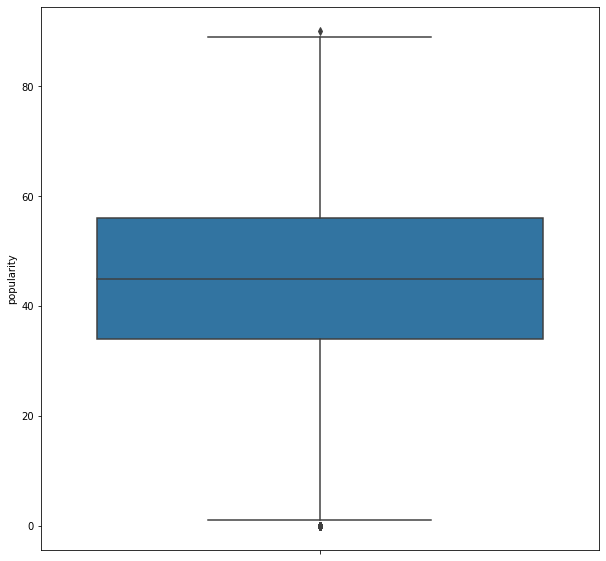

In [41]:
data.popularity.describe()
fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(y = data['popularity'], ax=ax )
# no extreme outliers
fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(y = data['popularity'], x = data['music_genre'], ax=ax )

## Variable acousticness
This variable provides information about the acoustics of the song.

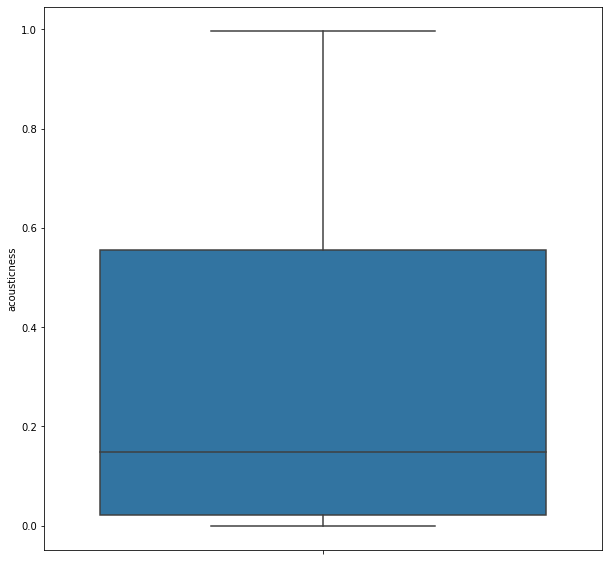

In [42]:
data.acousticness.describe()
fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(y = data['acousticness'], ax=ax )
# no extreme outliers
fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(y = data['acousticness'], x = data['music_genre'], ax=ax )

## Variable danceability
This variable provides information about the danceability of the song.

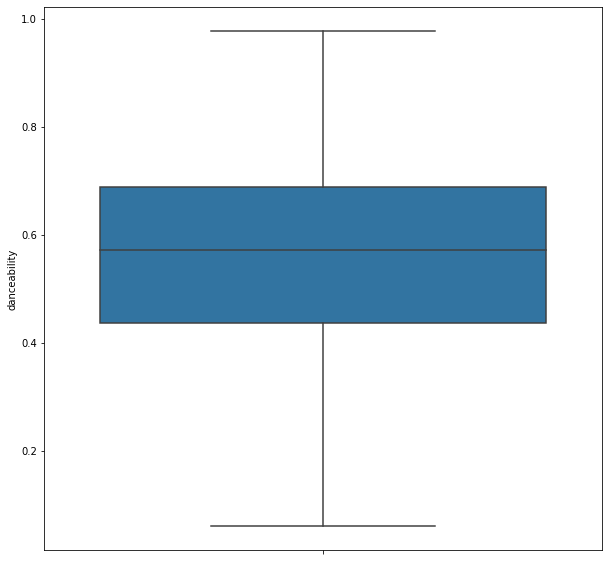

In [43]:
data.danceability.describe()
fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(y = data['danceability'], ax=ax )
# no extreme outliers

fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(y = data['danceability'], x = data['music_genre'], ax=ax )

## Variable duration_ms
This variable provides information about the duration of the song (in ms).

In [ ]:
data = data.rename(columns={'duration_ms': 'duration_s'})
data.duration_s.describe()
data['duration_s'] = data['duration_s'].apply(lambda x: x / 1000)
data.duration_s.describe()
fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(y = data['duration_s'], ax=ax )

fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(y = data['duration_s'], x = data['music_genre'], ax=ax )

# we have superior and inferior outliers
def find_outliers_tukey(x):
    q1 = np.nanpercentile(x, 25)
    q3 = np.nanpercentile(x, 75)
    iqr = q3-q1 
    floor = q1 - 3*iqr
    ceiling = q3 + 3*iqr
    outlier_indices = list(x.index[(x < floor)|(x > ceiling)])
    outlier_values = list(x[outlier_indices])

    return outlier_indices, outlier_values

llout,llout1 = find_outliers_tukey(data['duration_s'])
print(llout)
print(llout1)

error_indices = list(data['duration_s'].index[(data['duration_s'] <= 0)])
print(error_indices)
data.loc[error_indices, 'duration_s']
data.loc[error_indices, 'duration_s'] = np.nan
data.loc[error_indices, 'duration_s']

data.loc[llout, 'duration_s'] = np.nan

fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(y = data['duration_s'], ax=ax )

fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(y = data['duration_s'], x = data['music_genre'], ax=ax )

## Variable energy
Energy according to Spotify is the sense of forward motion in music, whatever keeps the listener engaged and listening. It is rated between 0 and 1.

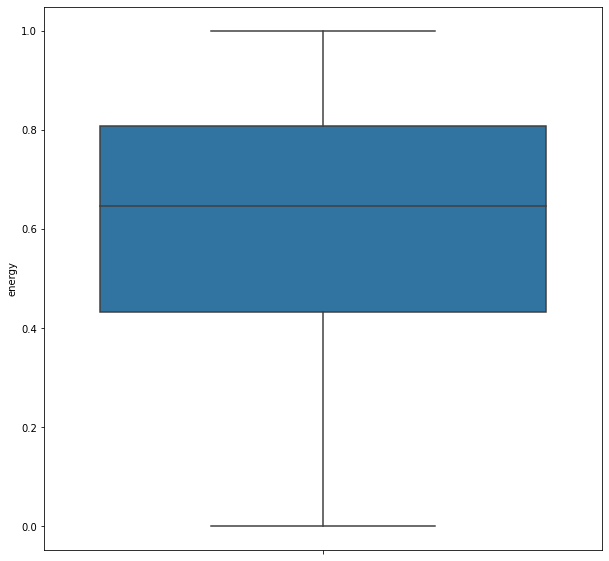

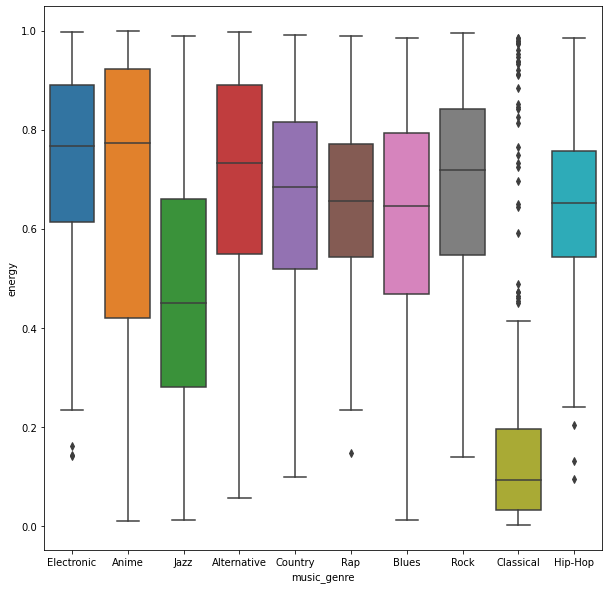

In [50]:
data.energy.describe()
fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(y = data['energy'], ax=ax )
# no extreme outliers
fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(y = data['energy'], x = data['music_genre'], ax=ax )



## Variable instrumentalness
This value represents the amount of vocals in the song. The closer it is to 1.0, the more instrumental the song is.





[3, 11, 14, 19, 26, 31, 34, 38, 39, 40, 42, 51, 52, 55, 61, 63, 79, 80, 81, 85, 93, 96, 98, 99, 102, 106, 107, 111, 114, 125, 128, 129, 130, 142, 145, 148, 150, 157, 160, 161, 162, 164, 169, 172, 174, 179, 188, 196, 198, 199, 204, 218, 221, 225, 236, 237, 242, 243, 244, 251, 252, 253, 254, 256, 269, 270, 273, 274, 275, 278, 282, 290, 291, 298, 301, 303, 309, 311, 313, 314, 316, 319, 321, 326, 327, 335, 343, 347, 351, 352, 354, 357, 365, 368, 370, 373, 374, 378, 381, 385, 387, 388, 391, 399, 400, 404, 405, 406, 414, 420, 421, 426, 431, 432, 443, 445, 453, 456, 461, 462, 463, 465, 489, 490, 493, 495, 498, 499, 502, 504, 508, 509, 510, 511, 512, 514, 519, 521, 525, 528, 531, 535, 536, 539, 545, 548, 553, 555, 556, 558, 562, 565, 568, 572, 573, 577, 579, 580, 582, 587, 592, 593, 595, 597, 609, 610, 617, 618, 631, 637, 644, 647, 654, 657, 676, 679, 680, 681, 691, 696, 698, 699, 702, 709, 711, 717, 721, 722, 724, 731, 734, 739, 742, 743, 747, 753, 757, 758, 763, 767, 773, 775, 780, 782, 787,

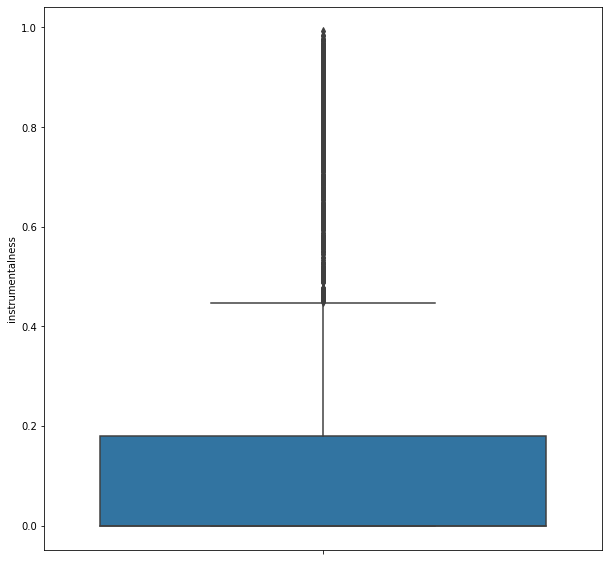

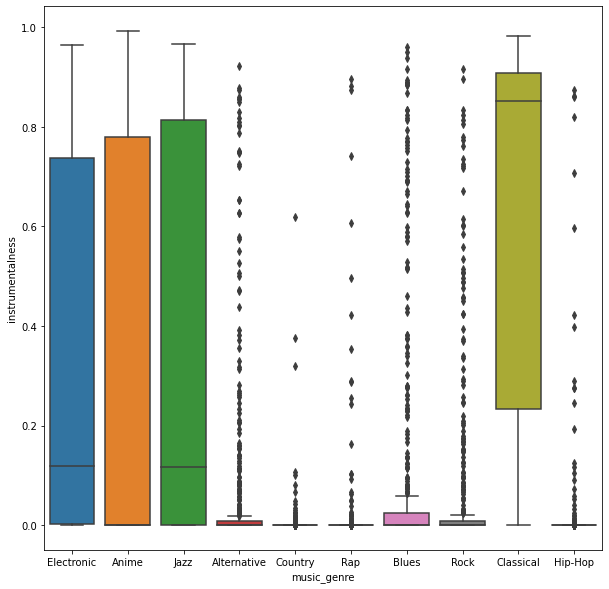

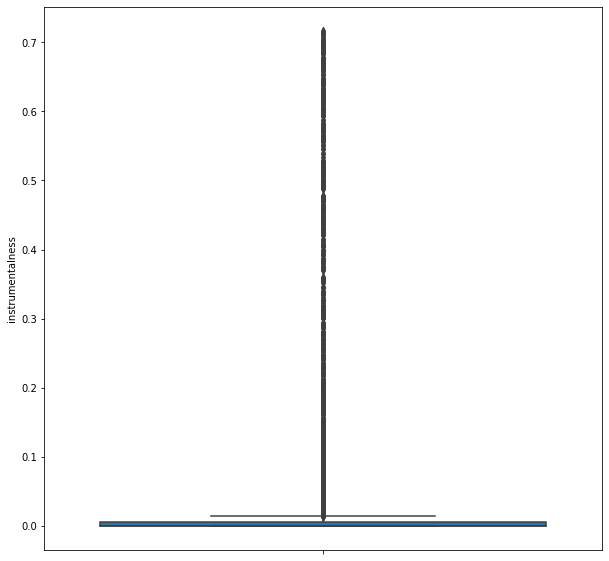

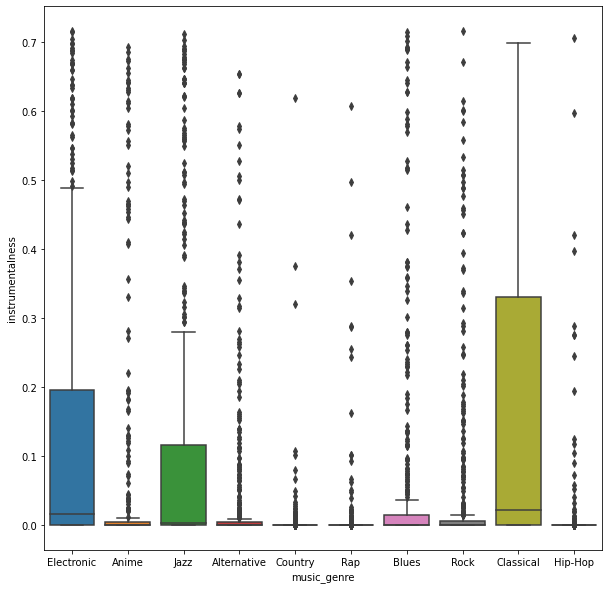

In [51]:
data.instrumentalness.describe()
# No errors (no values higher than 1 or lower than 0)
fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(y = data['instrumentalness'], ax=ax )
# no extreme outliers
fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(y = data['instrumentalness'], x = data['music_genre'], ax=ax )

# we have superior outliers
llout,llout1 = find_outliers_tukey(data['instrumentalness'])
print(llout)
print(llout1)

data.loc[llout, 'instrumentalness'] = np.nan

fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(y = data['instrumentalness'], ax=ax )
# no extreme outliers
fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(y = data['instrumentalness'], x = data['music_genre'], ax=ax )

## Variable key
This variable indicates the key of the song.


In [62]:
data.key.describe()
data['key'].value_counts().plot(kind='bar').set_title('Histogram of variable Key')

fig, ax = plt.subplots(figsize=(10,10))
sns.histplot(binwidth=0.5, x="music_genre", hue="key", data=data, stat="count", multiple="stack", ax=ax)

# Cross tabulation between GENDER and APPROVE_LOAN
CrosstabResult=pd.crosstab(index=data['music_genre'],columns=data['key'])
print(CrosstabResult)
 
# importing the required function
from scipy.stats import chi2_contingency
 
# Performing Chi-sq test
ChiSqResult = chi2_contingency(CrosstabResult)
 
# P-Value is the Probability of H0 being True
# If P-Value&gt;0.05 then only we Accept the assumption(H0)
 
print('The P-Value of the ChiSq Test is:', ChiSqResult[1])

The P-Value of the ChiSq Test is: 7.723444583578515e-30


## Variable liveness
This variable indicates the liveness of the song. This value describes the probability that the song was recorded with a live audience. According to the official documentation “a value above 0.8 provides strong likelihood that the track is live”.

[2, 30, 121, 158, 203, 264, 329, 370, 462, 468, 516, 579, 607, 677, 693, 704, 741, 771, 794, 820, 832, 849, 852, 898, 911, 1062, 1174, 1212, 1228, 1240, 1267, 1306, 1441, 1446, 1518, 1548, 1597, 1619, 1723, 1802, 1835, 1987, 1995, 2013, 2023, 2050, 2098, 2106, 2210, 2220, 2239, 2243, 2253, 2282, 2284, 2301, 2336, 2382, 2399, 2405, 2467, 2592, 2648, 2730, 2739, 2780, 2815, 2825, 2842, 2848, 2866, 2941, 2979, 3022, 3043, 3048, 3056, 3060, 3073, 3105, 3128, 3134, 3211, 3226, 3241, 3262, 3275, 3277, 3290, 3303, 3307, 3316, 3333, 3414, 3417, 3423, 3449, 3453, 3459, 3478, 3479, 3492, 3498, 3610, 3636, 3689, 3733, 3742, 3746, 3962, 3970, 4100, 4139, 4179, 4203, 4233, 4297, 4405, 4439, 4497, 4499, 4500, 4561, 4601, 4907, 4951, 4971, 4978]
[0.942, 0.865, 0.702, 0.818, 0.689, 0.822, 0.847, 0.687, 0.702, 0.692, 0.836, 0.692, 0.833, 0.775, 0.872, 0.879, 0.87, 0.84, 0.857, 0.943, 0.934, 0.742, 0.776, 0.686, 0.701, 0.753, 0.685, 0.708, 0.975, 0.734, 0.703, 0.695, 0.939, 0.702, 0.717, 0.696, 0.752, 0

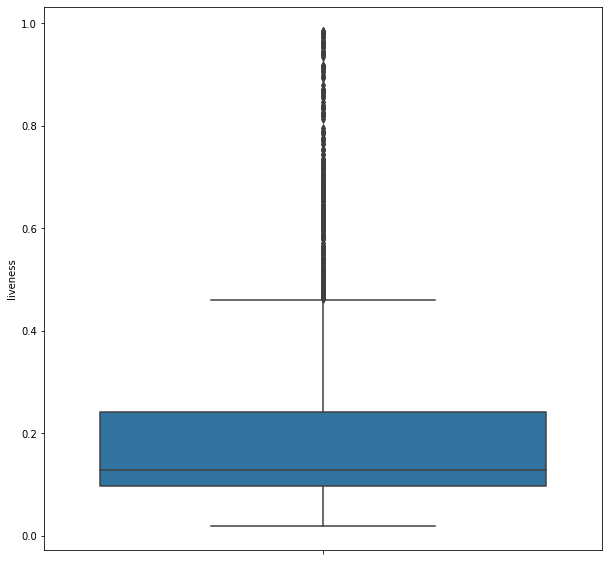

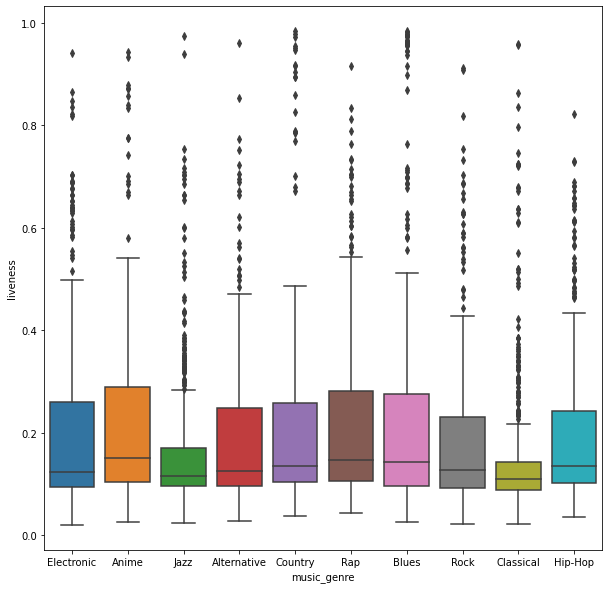

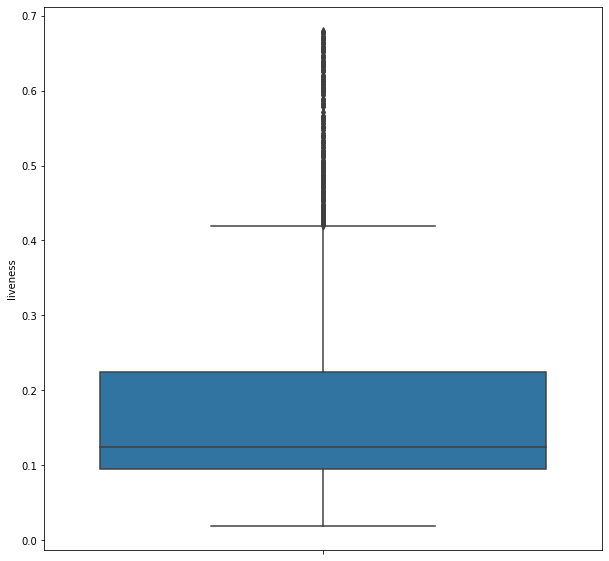

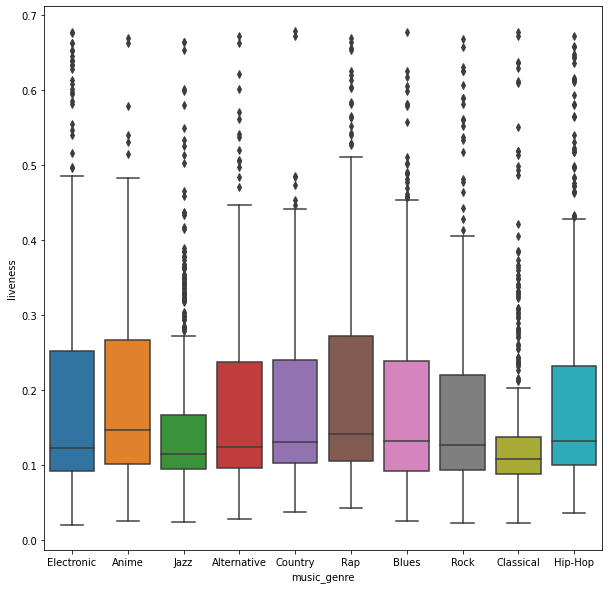

In [63]:
data.liveness.describe()
#No errors (no values higher than 1 or lower than 0)
fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(y = data['liveness'], ax=ax )
fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(y = data['liveness'], x = data['music_genre'], ax=ax )
llout,llout1 = find_outliers_tukey(data['liveness'])
print(llout)
print(llout1)

data.loc[llout, 'liveness'] = np.nan

fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(y = data['liveness'], ax=ax )
fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(y = data['liveness'], x = data['music_genre'], ax=ax )

## Variable loudness
This variable measures how loud a song sounds according to Spotify's LUFS.

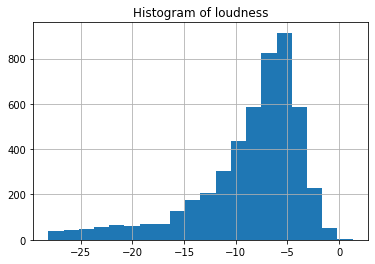

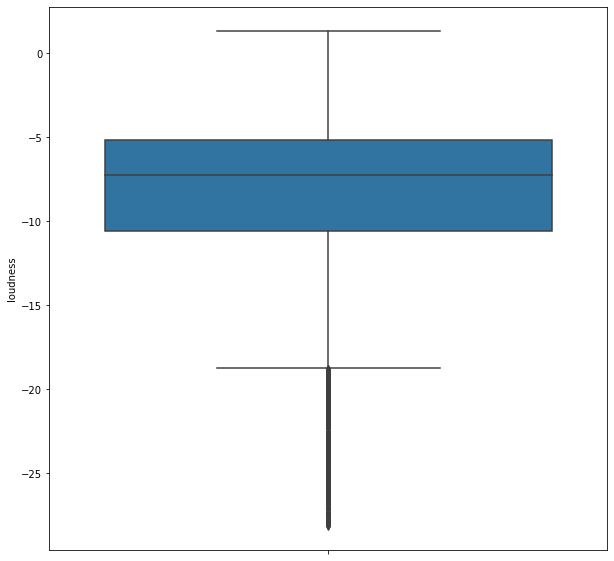

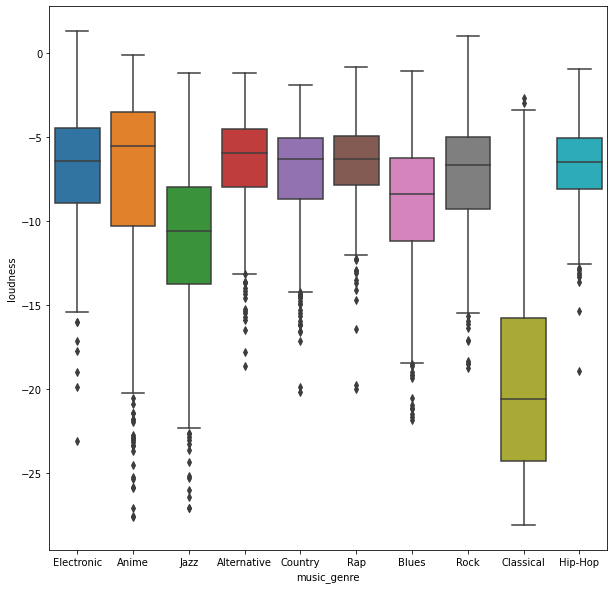

In [65]:
data.loudness.describe()
data.loudness.hist(bins=20).set_title('Histogram of loudness')
fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(y = data['loudness'], ax=ax )
fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(y = data['loudness'], x = data['music_genre'], ax=ax )
# the variable presents extreme inferior outliers

llout,llout1 = find_outliers_tukey(data['loudness'])
data.loc[llout, 'loudness'] = np.nan
hist = data.loudness.hist(bins=20).set_title('Histogram of loudness')

fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(y = data['loudness'], ax=ax )
fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(y = data['loudness'], x = data['music_genre'], ax=ax )


## Variable mode
Type of musical scale coupled with a set of characteristic melodic and harmonic behaviors. In the dataset it is applyed to major and minor keys.

mode         Major  Minor
music_genre              
Alternative  295    183  
Anime        315    172  
Blues        341    157  
Classical    313    182  
Country      425    65   
Electronic   275    248  
Hip-Hop      269    227  
Jazz         273    246  
Rap          282    236  
Rock         360    135  
The P-Value of the ChiSq Test is: 7.581211688223544e-44


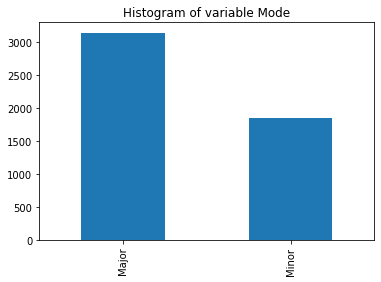

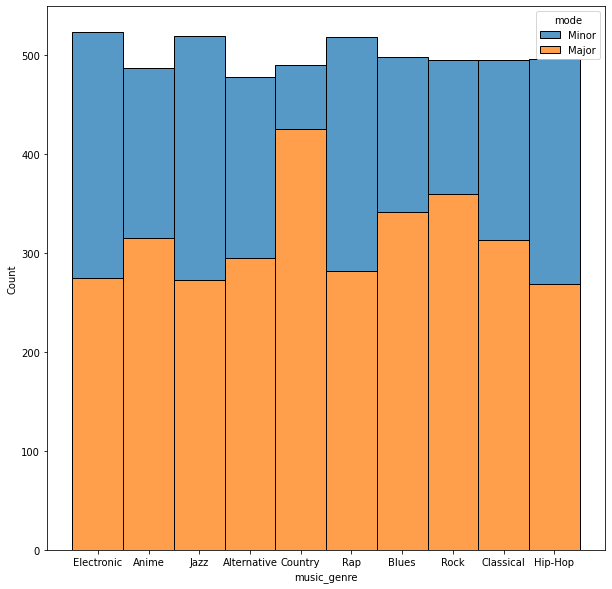

In [66]:
data['mode'].describe()
data['mode'].value_counts().plot(kind='bar').set_title('Histogram of variable Mode')
# no errors nor missing data

fig, ax = plt.subplots(figsize=(10,10))
sns.histplot(binwidth=0.5, x="music_genre", hue="mode", data=data, stat="count", multiple="stack", ax=ax)

# Cross tabulation between GENDER and APPROVE_LOAN
CrosstabResult=pd.crosstab(index=data['music_genre'],columns=data['mode'])
print(CrosstabResult)
 
# importing the required function
from scipy.stats import chi2_contingency
 
# Performing Chi-sq test
ChiSqResult = chi2_contingency(CrosstabResult)
 
# P-Value is the Probability of H0 being True
# If P-Value&gt;0.05 then only we Accept the assumption(H0)
 
print('The P-Value of the ChiSq Test is:', ChiSqResult[1])

## Variable speechiness
Speechiness detects the presence of spoken words in a track. If the speechiness of a song is above 0.66, it is probably made of spoken words, a score between 0.33 and 0.66 is a song that may contain both music and words, and a score below 0.33 means the song does not have any speech.

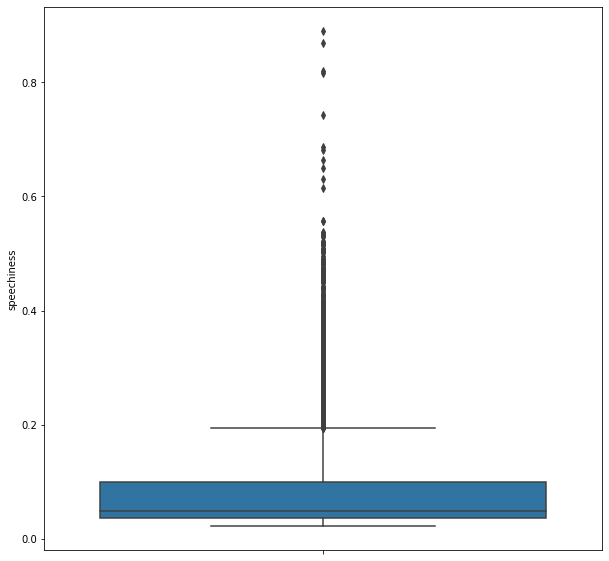

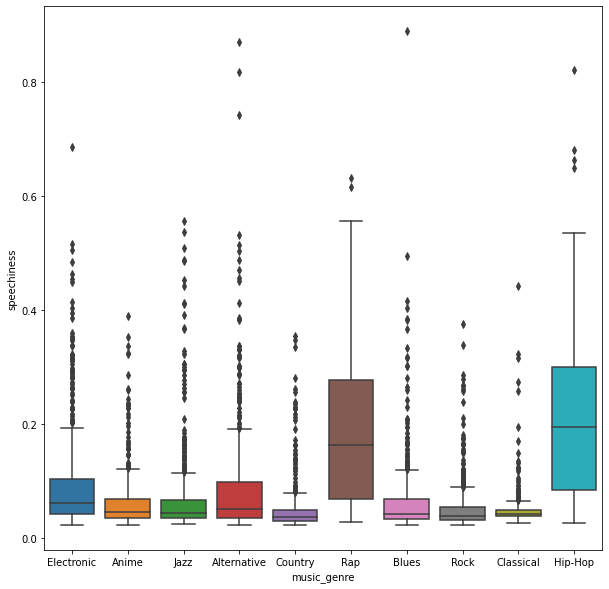

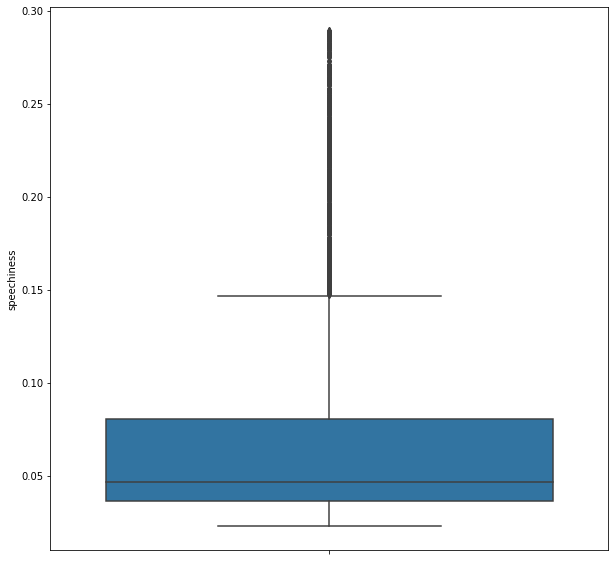

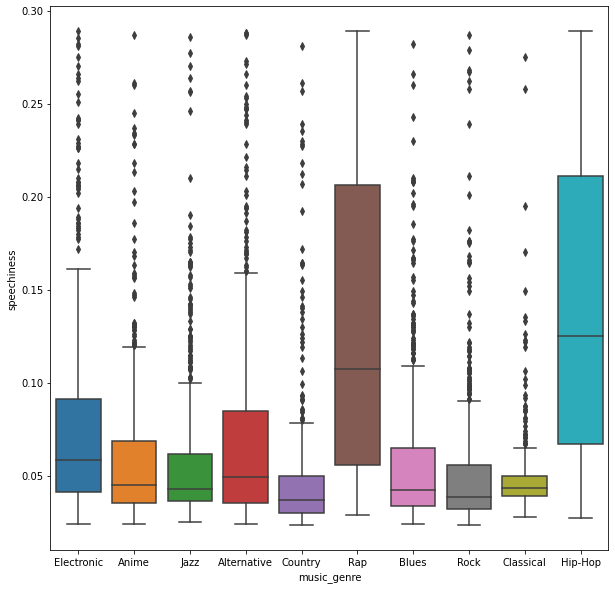

In [67]:
data['speechiness'].describe()
#No errors (no values higher than 1 or lower than 0)
fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(y = data['speechiness'], ax=ax )
fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(y = data['speechiness'], x = data['music_genre'], ax=ax )

llout,llout1 = find_outliers_tukey(data['speechiness'])
data.loc[llout, 'speechiness'] = np.nan

fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(y = data['speechiness'], ax=ax )
fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(y = data['speechiness'], x = data['music_genre'], ax=ax )

## Variable tempo
Variable tempo describes how fast or slow a piece of music is performed


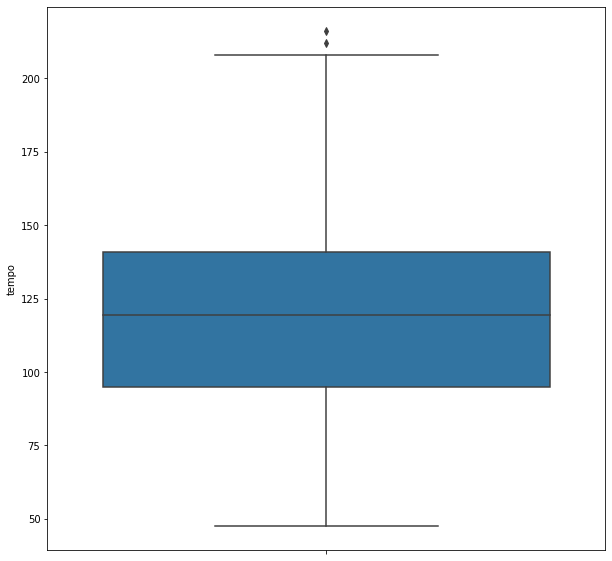

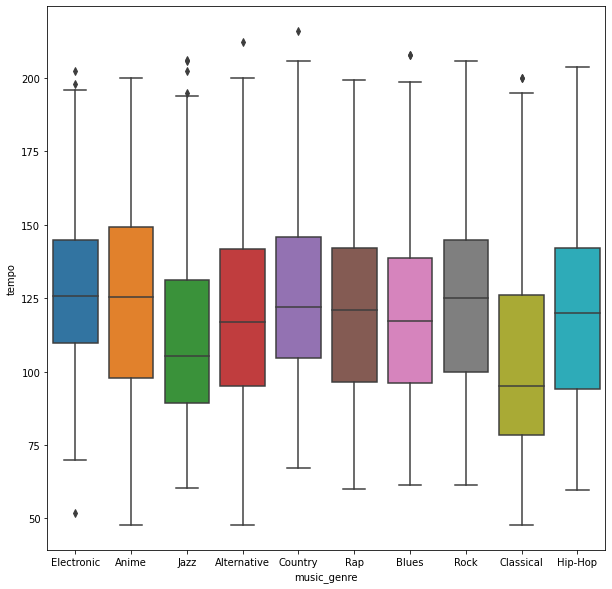

In [76]:
data['tempo'].describe()
#variable is numeric but due to missings it is being treated as object
nan_indices = list(data['tempo'].index[(data['tempo'] == '?')])
data.loc[nan_indices, 'tempo'] = np.nan
data['tempo'] = data['tempo'].astype(float)
data['tempo'].describe()

fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(y = data['tempo'], ax=ax )
fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(y = data['tempo'], x = data['music_genre'], ax=ax )
# no extreme outliers

## Variable obtained_date
We will detele this variable because it does not provide any significant data to help us with our predictions.

In [ ]:
data['obtained_date'].describe()
data = data.loc[:,data.columns!='obtained_date']

## Variable valence
This variable is a measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry)”.

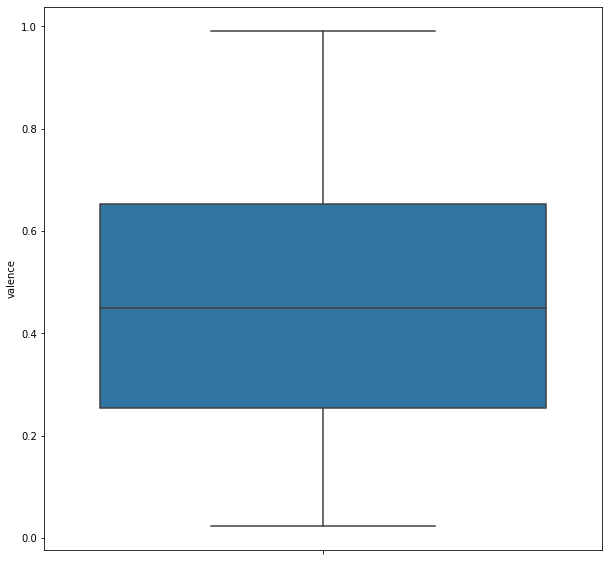

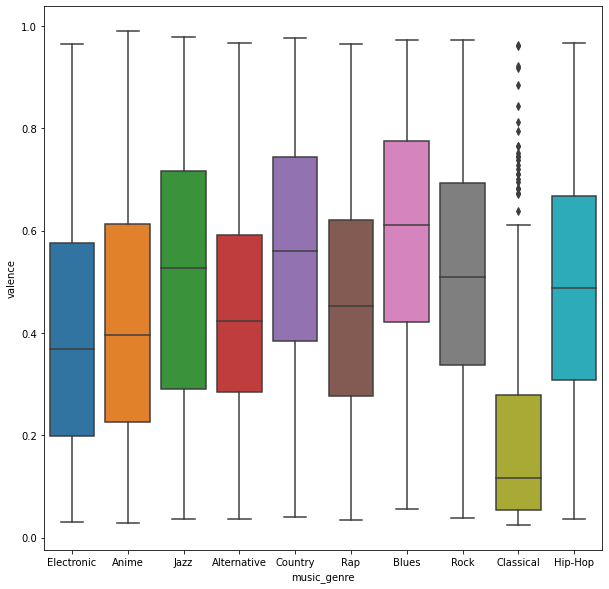

In [69]:
data['valence'].describe()
fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(y = data['valence'], ax=ax )
fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(y = data['valence'], x = data['music_genre'], ax=ax )
# no extreme outliers

## Variable music_genre

Text(0.5, 1.0, 'Histogram of variable music_genre')

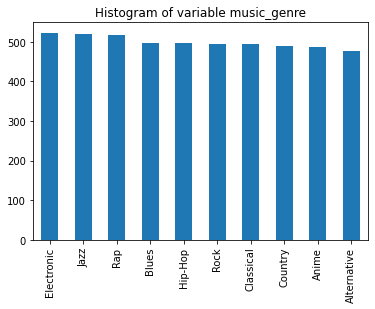

In [75]:
data['music_genre'].describe()
nan_indices = list(data['music_genre'].index[(data['music_genre'].isnull() )])
data.loc[nan_indices,]
# remove observation because is entirely null
data = data.drop([1010],axis=0)

data['music_genre'].value_counts().plot(kind='bar').set_title('Histogram of variable music_genre')

# Uni-variate description of the data

In [ ]:
data.describe(include='all')

,artist_name,track_name,popularity,acousticness,danceability,duration_s,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
count,4999,4999,4999.000,4999.000,4999.000,4419.000,4999.000,4182.000,4999,4871.000,4889.000,4999,4645.000,4507.000,4999.000,4999
unique,2327,4866,NaN,NaN,NaN,NaN,NaN,NaN,12,NaN,NaN,2,NaN,NaN,NaN,10
top,empty_field,Save Me,NaN,NaN,NaN,NaN,NaN,NaN,G,NaN,NaN,Major,NaN,NaN,NaN,Electronic
freq,273,4,NaN,NaN,NaN,NaN,NaN,NaN,556,NaN,NaN,3148,NaN,NaN,NaN,523
mean,NaN,NaN,44.461,0.307,0.559,236.936,0.598,0.054,NaN,0.176,-8.695,NaN,0.072,120.000,0.458,NaN
std,NaN,NaN,15.492,0.341,0.182,77.728,0.266,0.145,NaN,0.122,5.277,NaN,0.058,30.537,0.250,NaN
min,NaN,NaN,0.000,0.000,0.061,28.947,0.001,0.000,NaN,0.019,-28.124,NaN,0.023,47.704,0.024,NaN
25%,NaN,NaN,34.000,0.021,0.436,188.853,0.432,0.000,NaN,0.096,-10.600,NaN,0.036,94.989,0.254,NaN
50%,NaN,NaN,45.000,0.148,0.572,224.320,0.646,0.000,NaN,0.124,-7.241,NaN,0.047,119.490,0.449,NaN
75%,NaN,NaN,56.000,0.556,0.690,270.800,0.808,0.005,NaN,0.225,-5.161,NaN,0.081,140.863,0.653,NaN


#  Missing data

In [78]:
data.isnull().any()

instance_id         False
artist_name         False
track_name          False
popularity          False
acousticness        False
danceability        False
duration_ms         False
energy              False
instrumentalness    False
key                 False
liveness            False
loudness            False
mode                False
speechiness         False
tempo               True 
obtained_date       False
valence             False
music_genre         False
dtype: bool

In [80]:
data_num = data.select_dtypes(include=np.number)
imp = IterativeImputer(max_iter=10, random_state=0)
imputed_vals = pd.DataFrame(imp.fit_transform(data_num), columns=data_num.columns)
data = data.combine_first(imputed_vals)

data = data.dropna()
data.isnull().sum().sum()  # sum of nas in dataframe

data = data[['artist_name','track_name','popularity','duration_s','key','mode','tempo','valence',
              'acousticness','danceability','energy','instrumentalness','liveness','loudness','speechiness','music_genre']]
data.columns

In [ ]:
data.isnull().any()

artist_name         False
track_name          False
popularity          False
duration_s          False
key                 False
mode                False
tempo               False
valence             False
acousticness        False
danceability        False
energy              False
instrumentalness    False
liveness            False
loudness            False
speechiness         False
music_genre         False
dtype: bool

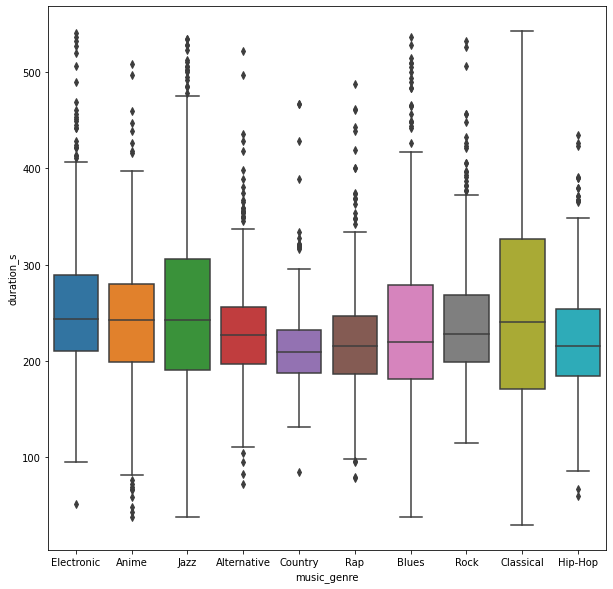

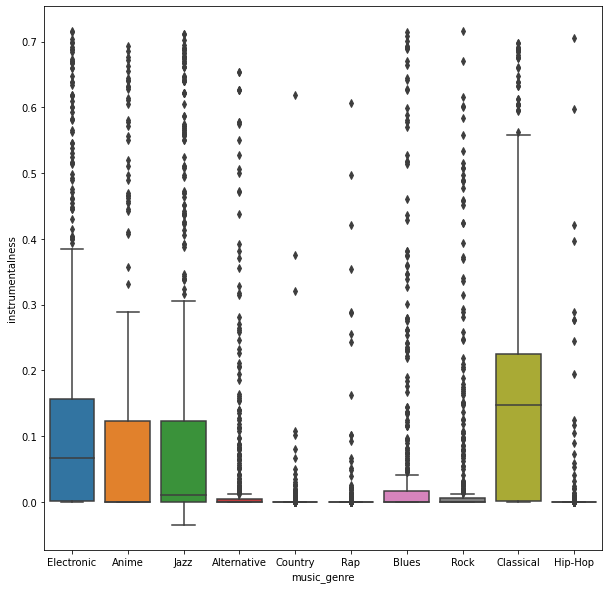

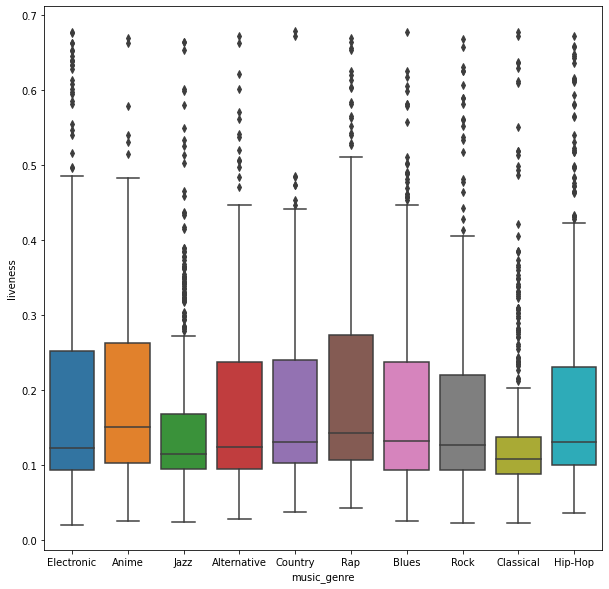

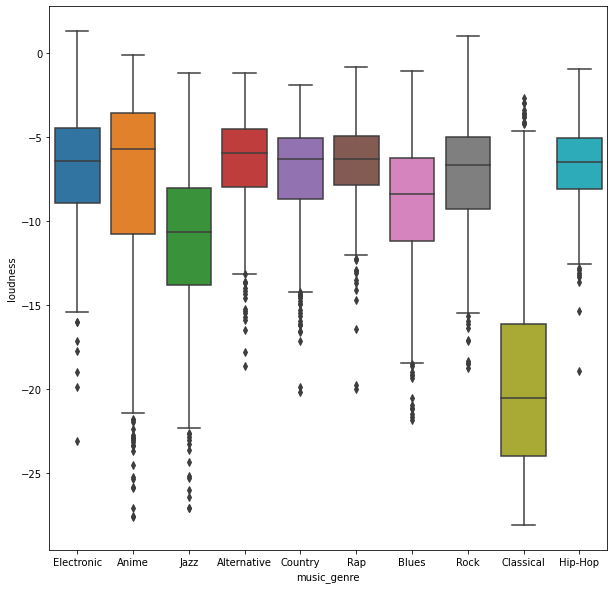

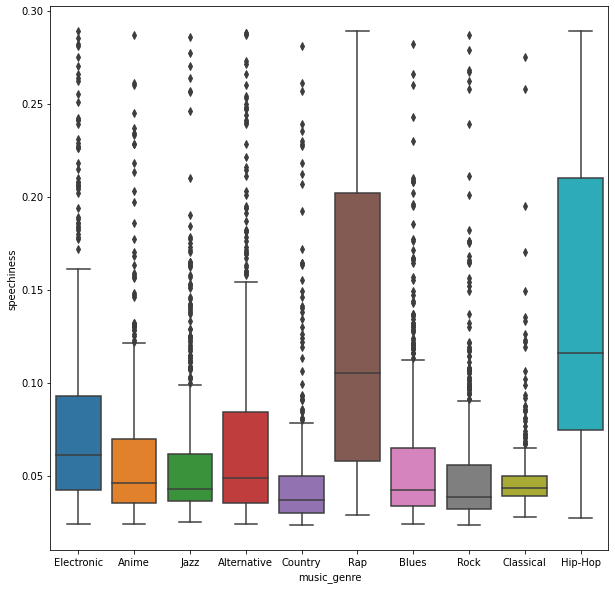

In [72]:
# check the consistency of the imputer
fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(y = data['duration_s'], x = data['music_genre'], ax=ax )
fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(y = data['instrumentalness'], x = data['music_genre'], ax=ax )
fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(y = data['liveness'], x = data['music_genre'], ax=ax )
fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(y = data['loudness'], x = data['music_genre'], ax=ax )
fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(y = data['speechiness'], x = data['music_genre'], ax=ax )

## Multivariant outliers

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



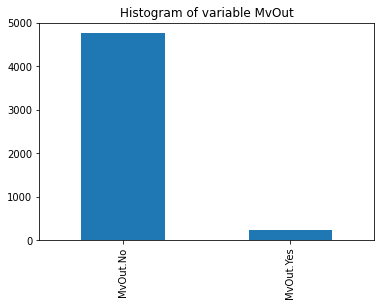

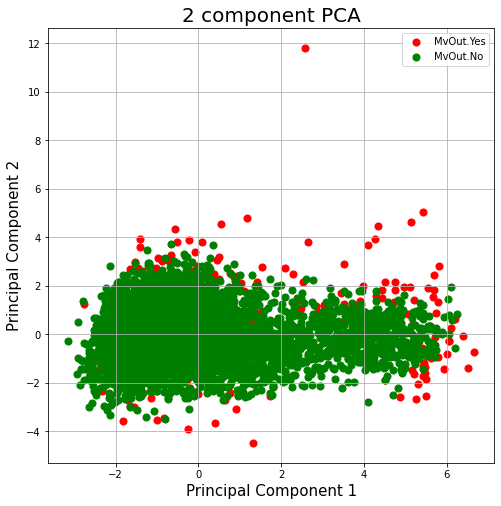

In [81]:
def mahalanobis_method(df):
    #M-Distance
    x_minus_mu = df - np.mean(df)
    cov = np.cov(df.values.T)                           #Covariance
    inv_covmat = sp.linalg.inv(cov)                     #Inverse covariance
    left_term = np.dot(x_minus_mu, inv_covmat) 
    mahal = np.dot(left_term, x_minus_mu.T)
    md = np.sqrt(mahal.diagonal())
    
    #Flag as outlier
    outlier = []
    #Cut-off point
    C = np.sqrt(chi2.ppf((1-0.005), df=df.shape[1]))    #degrees of freedom = number of variables
    for index, value in enumerate(md):
        if value > C:
            outlier.append(index)
        else:
            continue
    return outlier, md

def robust_mahalanobis_method(df):
    rng = np.random.RandomState(0)
    real_cov = np.cov(df.values.T)
    X = rng.multivariate_normal(mean=np.mean(df, axis=0), cov=real_cov, size=506)
    cov = MinCovDet(random_state=0).fit(X)
    mcd = cov.covariance_ #robust covariance metric
    robust_mean = cov.location_  #robust mean
    inv_covmat = sp.linalg.inv(mcd) #inverse covariance metric
    
    x_minus_mu = df - robust_mean
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    md = np.sqrt(mahal.diagonal())
    
    outlier = []
    C = np.sqrt(chi2.ppf((1-0.005), df=df.shape[1])) #degrees of freedom = number of variables
    for index, value in enumerate(md):
        if value > C:
            outlier.append(index)
        else:
            continue
    return outlier, md

  

data_num = data.select_dtypes(include=np.number)

outliers_mahal_bi, md_bi = mahalanobis_method(df=data_num) # 0.995 confidence interval
outliers_mahal_rob, md_rob = robust_mahalanobis_method(df=data_num)
#plot = plt.scatter(data.loc[:, 'acousticness'], data.loc[:, 'danceability'], color='blue')
#plot = plt.scatter(data.loc[outliers_mahal_bi, 'acousticness'], data.loc[outliers_mahal_bi, 'danceability'], color='red')

data = data.loc[:, data.columns!='MvOut']
data.insert(len(data.columns), "MvOut", "MvOut.No")
for i in range(len(outliers_mahal_bi)):
  data['MvOut'][outliers_mahal_bi[i]]="MvOut.Yes"

for i in range(len(outliers_mahal_rob)):
  data['MvOut'][outliers_mahal_rob[i]]="MvOut.Yes"

data['MvOut'].value_counts().plot(kind='bar').set_title('Histogram of variable MvOut')

from sklearn.preprocessing import StandardScaler
data_num = StandardScaler().fit_transform(data_num)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(data_num)
principalDf = pandas.DataFrame(data = principalComponents ,columns = ['principal component 1', 'principal component 2'])

finalDf = pandas.concat([principalDf, data[['MvOut']]], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['MvOut.Yes', 'MvOut.No']
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['MvOut'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1'] ,finalDf.loc[indicesToKeep, 'principal component 2'], c = color, s = 50)
ax.legend(targets)
ax.grid()

data = data[data.MvOut == 'MvOut.No'] # remove multivariant outliers
data = data.drop('MvOut', axis=1)

##Save dataframe into csv

In [ ]:
data.to_csv('sample_5000_sin_outliers.csv')

# Bibiography
https://www.musicianonamission.com/spotify-lufs/#:~:text=LUFS%20measure%20how%20loud%20a,ll%20want%20to%20use%20LUFS
https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
https://towardsdatascience.com/detecting-and-treating-outliers-in-python-part-2-3a3319ec2c33
https://www.machinelearningplus.com/plots/python-scatter-plot/
https://datatofish.com/check-nan-pandas-dataframe/
https://www.geeksforgeeks.org/grouped-boxplots-in-python-with-seaborn/


